### Time series

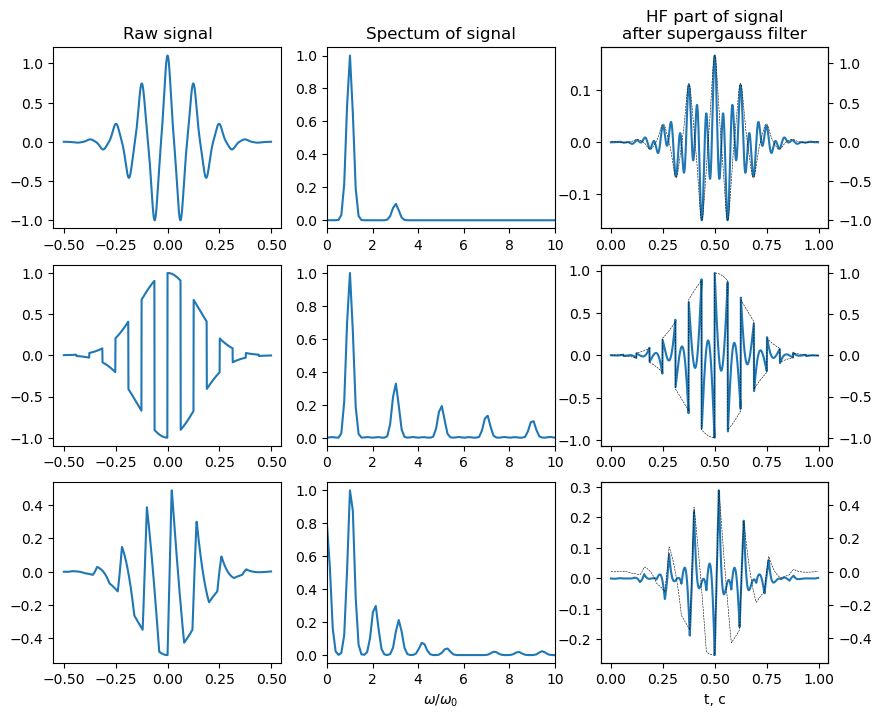

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from os.path import join

from PIC_data_processing.time_series import plot_spectra, plot_HF_part
from scipy.signal import square

N = 1024
dt = 1 / N
t = np.arange(-N // 2, N // 2) * dt

w0 = 50 # central frequency
τ = 0.2 # pulse lenght
# cos pulse with third harmonic
S_harm = np.exp(-(t / τ) ** 2) * (np.cos(w0 * t) + 0.1 * np.cos(3 * w0 * t)) 

# square-wave waveform
S_sq = np.exp(-(t / τ) ** 2) * square(w0 * t, duty = 0.5)#(np.cos(w0 * t) + 1)/2)

# triangular pulse 
# (copied from https://stackoverflow.com/questions/56345583/positive-triangle-pulse-in-python)
rise_duration = 1
fall_duration = 3
period = 6

control_points_x = [0, rise_duration, rise_duration+fall_duration]
control_points_y = [0, 1, 0]

S_tr = np.exp(-(t / τ) ** 2) * (np.interp( w0 * t, control_points_x, control_points_y, period=period)-0.5)

    
fig, axs = plt.subplots(3, 3,figsize = (10, 8))
axs[0, 0].plot(t, S_harm)
axs[1, 0].plot(t, S_sq)
axs[2, 0].plot(t, S_tr)

# passing unit_y = None to remove ylabel
plot_spectra(fig, axs[:, 1], [S_harm, S_sq, S_tr], dt,\
             yscale = 'linear', unit_x = ['$\omega/\omega_0$', w0],
             xlim = [0, 10], unit_y = [None, 'max'])

def pass_filter_fn(w):
    w /= w0
    return 1 - np.exp(-(w/2) ** 4)

plot_HF_part(fig, axs[:, 2], [S_harm, S_sq, S_tr], dt, pass_filter_fn,\
             unit_hf = [None, 1], unit_full = [None, 1], show_legend = False, sqr_hf = False);
axs[0, 0].set_title('Raw signal')
axs[0, 1].set_title('Spectum of signal')
axs[0, 2].set_title('HF part of signal\nafter supergauss filter');

### xt-maps

C:\Users\lenovo\PIC


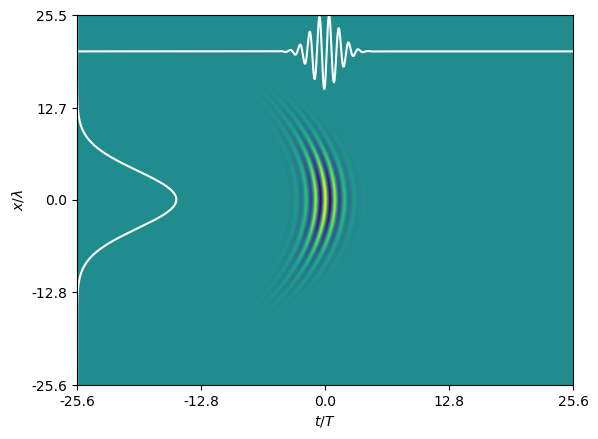

In [12]:
import os
import numpy as np
import matplotlib.pyplot as plt
from os.path import join
%cd C:\Users\lenovo\PIC
from PIC_data_processing.xt_maps import plot_xt

λ = 800e-9
c = 3e8
T = λ / c
k = 2 * np.pi / λ
ω = 2 * np.pi / T
τ = 2 * T
w = 8 * λ
R = -20 * λ
α = np.pi / 4


dx = λ / 10
dt = 0.5 * dx / c
Nt = 1024
Nx = 512

t = np.arange(-Nt / 2, Nt / 2) * dt
x = np.arange(-Nx / 2, Nx / 2) * dx
x, t = np.meshgrid(x, t)

# ph =  0.5 * k * (x + 0e-6 * np.sin(x/λ)) ** 2 / R
ph =  0.5 * k * (x + 0e-6 * np.sin(x/λ)) ** 2 / R
E_xt = np.exp(- (x / w) ** 2 - ((t - ph / ω) / τ) ** 2) * np.cos(ω * t - ph)

fig, axs = plt.subplots()
plot_xt(fig, axs, E_xt, x[0] / λ, t[:, 0] / T, axis_sum = [0, 1], sqr_sum = [True, False])
axs.set_ylabel('$x/\lambda$')
axs.set_xlabel('$t/T$');

#### diffraction compensation

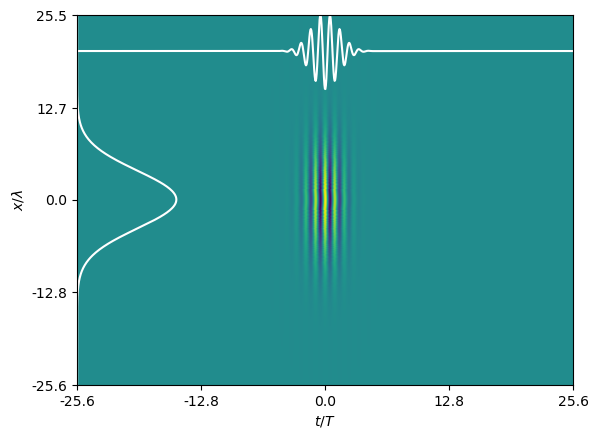

In [13]:
from PIC_data_processing.xt_maps import  compensate_curvature
fig, axs = plt.subplots()
E_xt_comp = compensate_curvature(E_xt)
plot_xt(fig, axs, E_xt_comp, x[0] / λ, t[:, 0] / T, axis_sum = [0, 1], sqr_sum = [True, False])
axs.set_ylabel('$x/\lambda$')
axs.set_xlabel('$t/T$');

#### x-$\omega$ spectum

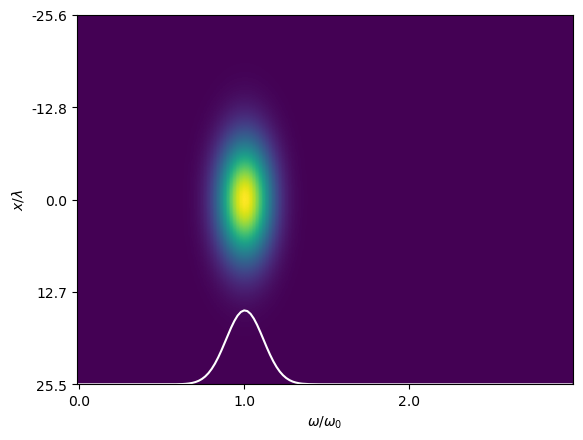

In [14]:
from PIC_data_processing.math_utils import F, F2
E_xw = np.abs(F(E_xt))[Nt//2:]
ωpos = np.linspace(0, 0.5, Nt//2) * 2 * np.pi / dt
fig, axs = plt.subplots()
plot_xt(fig, axs, E_xw, x[0] / λ, ωpos / ω, axis_sum = [1], tlim = [0, 3], num_tticks = 4, round_t = 1)
axs.set_ylabel('$x/\lambda$')
axs.set_xlabel('$ω/ω_0$');

#### $\theta$-$\omega$ map

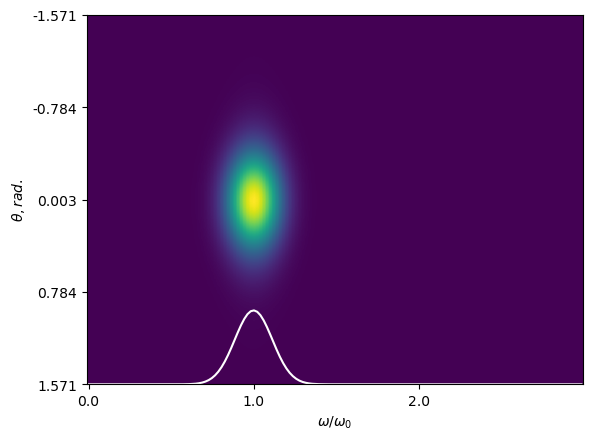

In [17]:
from PIC_data_processing.xt_maps import kw2angle_w
E_kw = np.abs(F2(E_xt))[Nt//2:]
ωpos = np.linspace(0, 0.5, Nt//2) * 2 * np.pi / dt
kx = np.linspace(-0.5, 0.5, Nx) * 2 * np.pi / dx 

theta, ωpos, E_aw = kw2angle_w(kx, ωpos, E_kw)
fig, axs = plt.subplots()
plot_xt(fig, axs, E_aw, theta, ωpos / ω, axis_sum = [1], tlim = [0, 3],\
        num_tticks = 4, round_t = 1)
axs.set_ylabel('$θ, rad.$')
axs.set_xlabel('$ω/ω_0$');

### xy-maps

C:\Users\lenovo\PIC


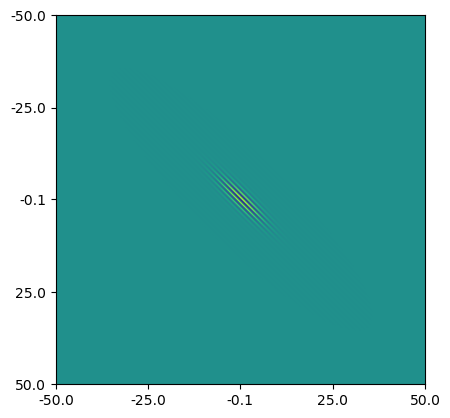

In [18]:
import os
import numpy as np
import matplotlib.pyplot as plt
from os.path import join
%cd C:\Users\lenovo\PIC
from PIC_data_processing.xy_maps import plot_xy
from PIC_data_processing.xt_maps import plot_xt
from PIC_data_processing.math_utils import cart2pol_interp, F2

λ = 800e-9
c = 3e8
T = λ / c
k = 2 * np.pi / λ
ω = 2 * np.pi / T
τ = 2 * T
w = 8 * λ
R = -20 * λ
α = np.pi / 4

Nx, Ny = 512, 512
x, y = np.linspace(-50 * λ, 50 * λ, Nx), np.linspace(-50 * λ, 50 * λ, Ny)
dx, dy = x[1] - x[0], y[1] - y[0]
x, y = np.meshgrid(x, y)
xr, yr = (x * np.sin(α) + y * np.cos(α)), (x * np.cos(α) - y * np.sin(α))
E_xy = np.exp(-(xr / w) ** 2) * np.exp(-(yr / (c * τ)) ** 2) * np.sin(k * yr)

fig, axs = plt.subplots()
plot_xy(fig, axs, E_xy, x[0] / λ, y[:, 0] / λ)
axs.set_aspect('equal')

#### angle-frequency spectrum

Text(0, 0.5, '$\\theta^{\\circ}$')

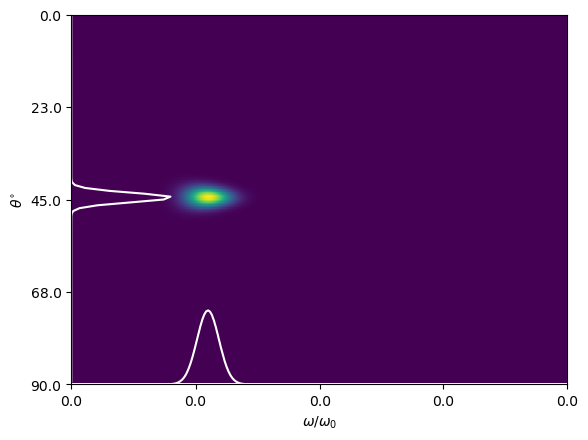

In [19]:
E_kxky = np.abs(F2(E_xy))
kx, ky = np.linspace(-0.5, 0.5, Nx) * 2 * np.pi / dx, np.linspace(-0.5, 0.5, Ny) * 2 * np.pi / dy
freq, angle, E_angle_freq = cart2pol_interp(kx, ky, E_kxky)
angle, E_angle_freq = angle[:len(angle)//2], E_angle_freq[:len(angle)//2]
freq /= k
fig, axs = plt.subplots()

plot_xt(fig, axs, E_angle_freq.T, angle, freq,\
        num_tticks = 5, round_t = 0, xlim = [0, 90], round_x = 2, axis_sum = [0, 1], sqr_sum = [True, True])
axs.invert_yaxis()
axs.set_xlabel('$\omega/\omega_0$')
axs.set_ylabel(r'$\theta^{\circ}$')

#### density&field maps

C:\Users\lenovo\PIC


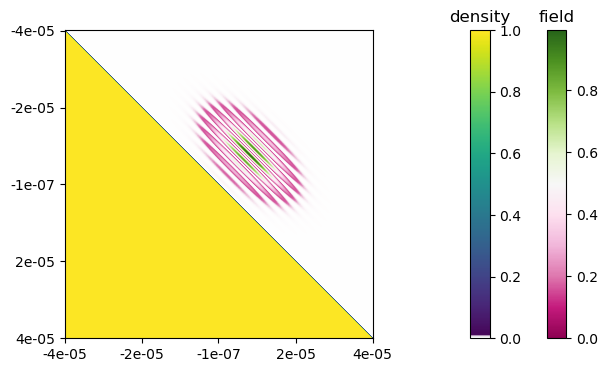

In [20]:
import os
import numpy as np
import matplotlib.pyplot as plt
from os.path import join
%cd C:\Users\lenovo\PIC
from PIC_data_processing.xy_maps import plot_overlap_maps
from PIC_data_processing.plot_utils import add_transparency, with_white

λ = 4000e-9
c = 3e8
T = λ / c
k = 2 * np.pi / λ
ω = 2 * np.pi / T
τ = 2 * T
w = 4 * λ
R = -20 * λ
α = np.pi / 4

Nx, Ny = 512, 512
x, y = np.linspace(-10 * λ, 10 * λ, Nx), np.linspace(-10 * λ, 10 * λ, Ny)
dx, dy = x[1] - x[0], y[1] - y[0]
x, y = np.meshgrid(x, y)
dens = (x < y).astype('float64')
xr, yr = (x * np.sin(α) + y * np.cos(α)), (x * np.cos(α) - y * np.sin(α))
field = E_xy = np.exp(-((xr) / w) ** 2) * np.exp(-((yr-0.7*w) / (c * τ)) ** 2) * np.sin(k * yr)

fig, axs = plt.subplots(1, 3, gridspec_kw = {
    'wspace': 0.4,'width_ratios':[1, 0.05, 0.05]}, figsize = (7, 4))
plot_overlap_maps(fig, axs, dens, field ** 2, x[0], y[:, 0],\
                  imshow2_kwargs = {'cmap': add_transparency(plt.cm.PiYG,\
                                                             lambda t:1 / (1 + np.exp((-0.1+t) * -50)))},\
                 imshow1_kwargs = {'cmap': with_white(plt.cm.viridis, 0, 4)})
axs[1].set_title('density')
axs[2].set_title('field')
axs[0].set_aspect('equal')